In [1]:
import os
import wfdb
import pickle
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import load_model
import seaborn as sns
from utils import drop_repeat,cal_cross_validated,generate_marker,BlurPooling1D
np.set_printoptions(suppress=True)
from keras.utils import CustomObjectScope
%matplotlib inline

/Users/hu/.pyenv/versions/3.6.6/envs/Biosignals/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/hu/.pyenv/versions/3.6.6/envs/Biosignals/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


In [2]:
result_df = pd.read_csv("final_result.csv",index_col="idx")
result_df = result_df.drop('Unnamed: 0',axis=1)

result_df_crossed = pd.read_csv("final_result_crossed.csv")
result_df_crossed = result_df_crossed.drop('Unnamed: 0',axis=1)

In [3]:
result_df_crossed.head()

,pool_factor,pool_type,marker,loss,accuracy,consis_b,consis_b_std,consis_ub,consis_n,consis_a,consis_a_s,robustness,with_augment
0,1,max,$M$,1.049271,0.908876,0.983427,0.019407,0.984589,0.967717,0.987592,0.999136,0.912728,True
1,1,avg,$A$,0.731480,0.937249,0.980399,0.018135,0.986580,0.962649,0.990979,0.998148,0.882716,True
2,1,maxblur-3,^,0.971300,0.919108,0.973950,0.027617,0.979517,0.949331,0.984997,0.998569,0.783951,True
3,1,maxblur-4,D,0.820239,0.924234,0.970100,0.025586,0.973017,0.956744,0.975896,0.983456,0.838654,True
4,1,maxblur-5,p,0.934157,0.891491,0.955689,0.043245,0.953658,0.957944,0.952779,0.953434,0.877980,True


In [27]:
def print_order(improvement):
    improv_order = np.argsort(improvement)
    improv_order_str = [str(idx+1) + "-CNN" for idx in improv_order]
    string = ""
    for _str in improv_order_str:
        string = string+ _str + "<"
    return string[:-1]

## Improvement :  baseline vs Maxblur

In [30]:
def plot_improvement(df,method="maxblur-7",baseline="max",x="accuracy",y="consis_b"):
    plt.figure(figsize=(9,7))
    #plt.title("Maxblur Pooling improvements compared to baseline",fontsize=20)
    improvement = []
    for pool_factor in [1,2,3]:
        if pool_factor == 1:
            c = "b"
        elif pool_factor == 2:
            c = "r"
        else:
            c = "purple"
        label_method = str(pool_factor)+"-layer CNN " + method
        label_baseline = str(pool_factor)+"-layer CNN " + baseline
        start_x = float(df[(df.pool_factor==pool_factor)&(df.pool_type==baseline)][x])
        start_y =float( df[(df.pool_factor==pool_factor)&(df.pool_type==baseline)][y])
        end_x = float(df[(df.pool_factor==pool_factor)&(df.pool_type==method)][x])
        end_y = float(df[(df.pool_factor==pool_factor)&(df.pool_type==method)][y])
        plt.scatter(start_x,start_y,edgecolors=c,marker="o",c="w",label=label_baseline,s=200)
        
        plt.scatter(end_x,end_y,edgecolors=c,marker="o",c=c,label=label_method,s=200)
        plt.annotate('', xy=[end_x,end_y],xytext=[start_x,start_y],
            arrowprops=dict(headwidth=10,
                            connectionstyle='arc3',
                            facecolor=c, 
                            edgecolor=c))
        
        improvement.append(end_x-start_x + end_y-start_y)

    title = print_order(improvement)
    plt.title(title,fontsize=20)
    plt.xlabel("Accuracy",fontsize=20)
    plt.ylabel("Consistency",fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(0.72,1.0)
    plt.ylim(0.72,1.0)
    plt.legend(fontsize=15,loc="upper left")

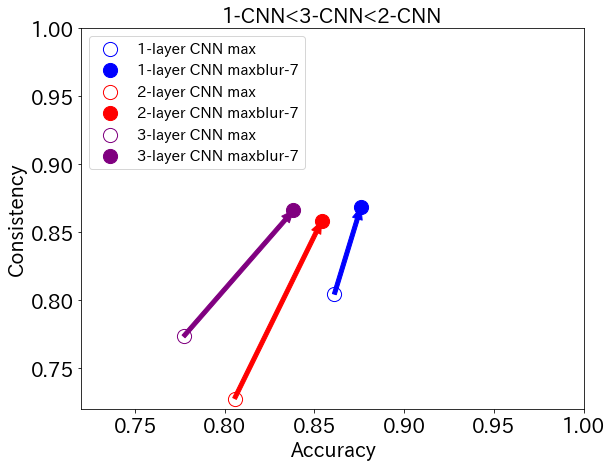

In [31]:
plot_improvement(df=result_df_crossed[result_df_crossed.with_augment==False],baseline="max",method="maxblur-7")

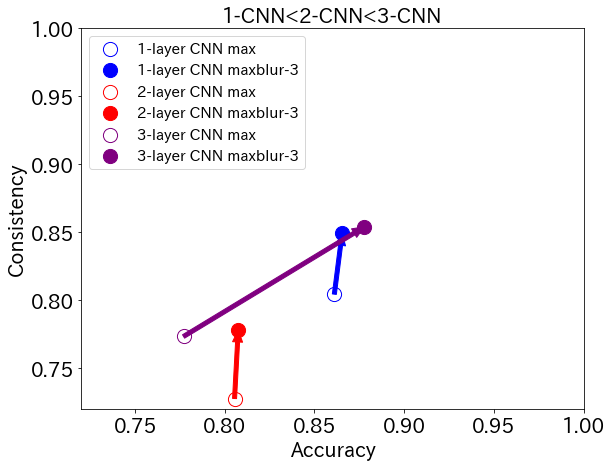

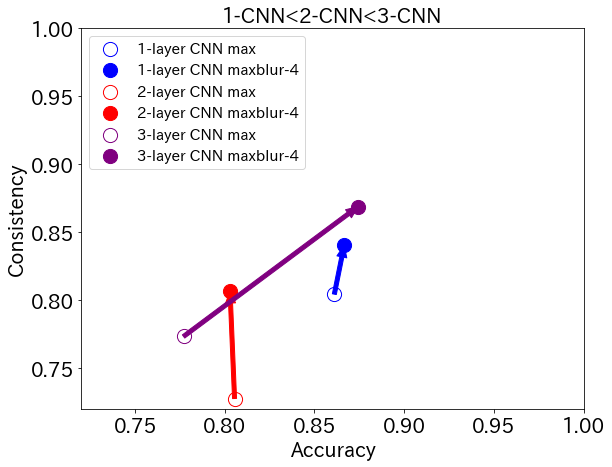

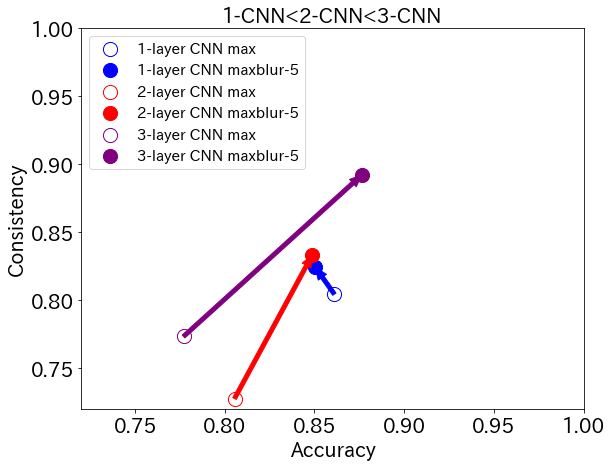

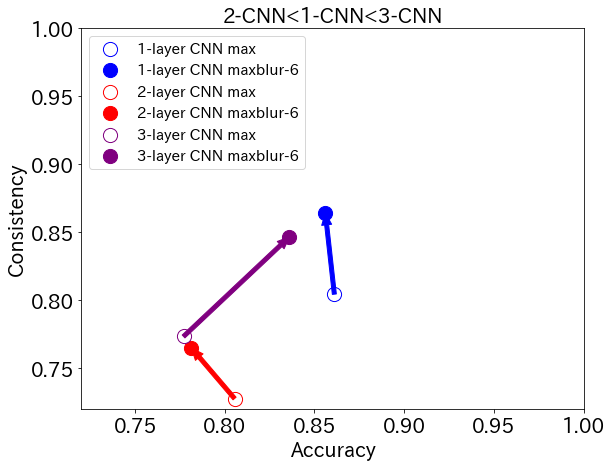

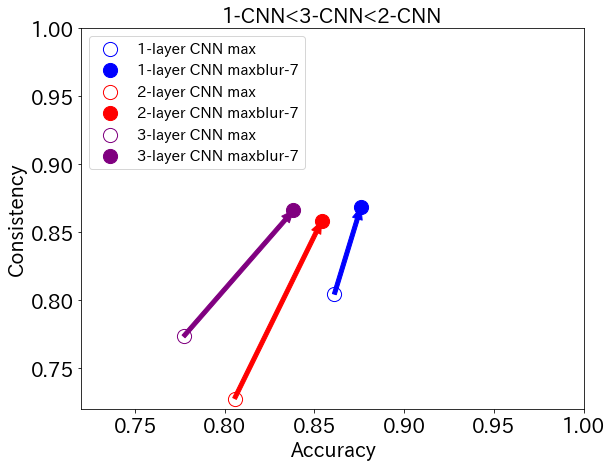

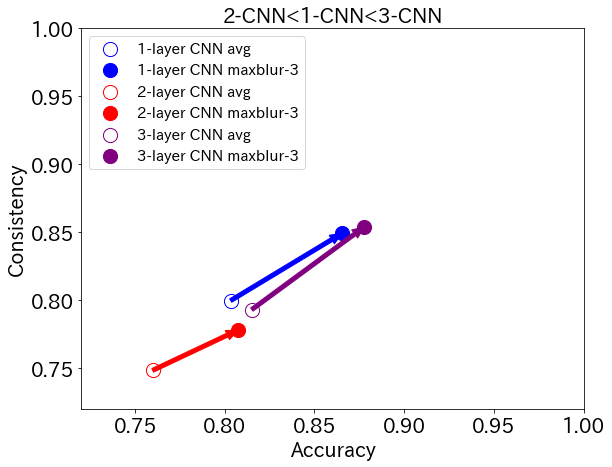

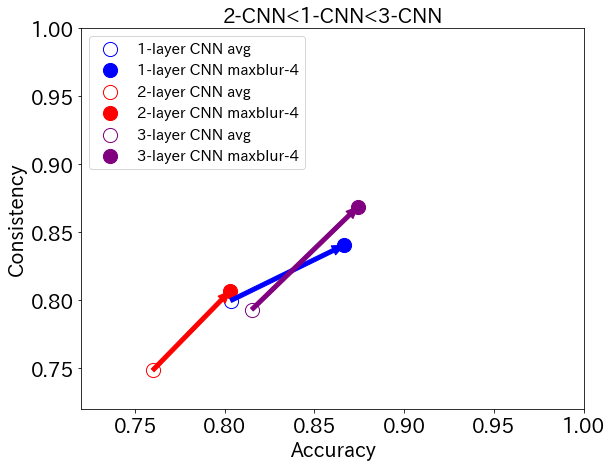

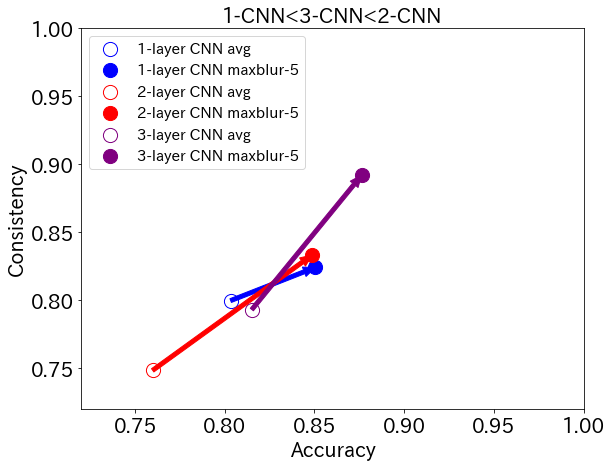

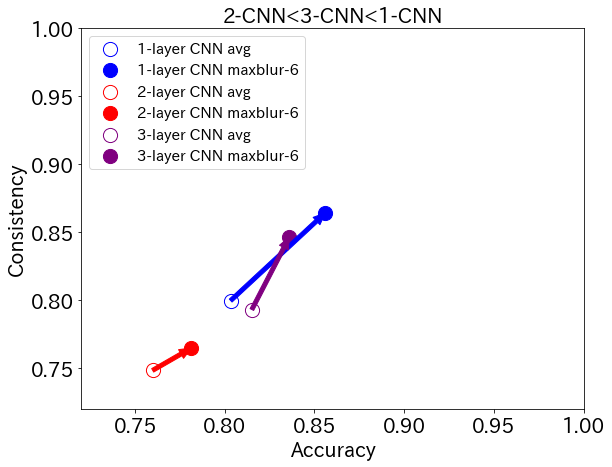

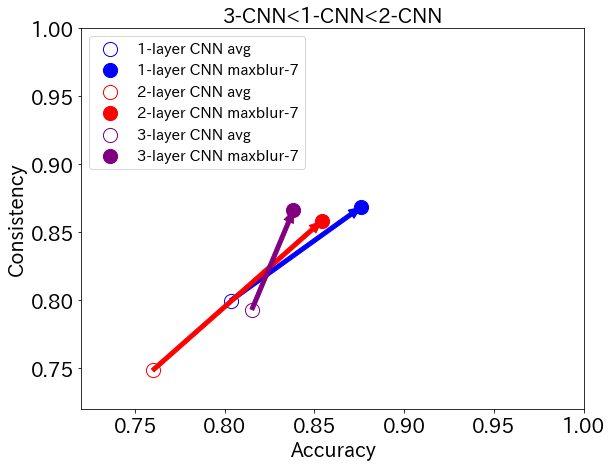

In [32]:
for baseline in ["max","avg"]:
    for method in ["maxblur-" + str(i+3) for i in range(5)]:
        plot_improvement(df=result_df_crossed[result_df_crossed.with_augment==False],baseline=baseline,method=method)
        save_path = os.path.join("figs/",method+" vs "+baseline+".png")
        plt.savefig(save_path)